# Turing Target Practice

## Model

In [22]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [23]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot

using Revise
using MicroCanonicalHMC

In [24]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [25]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [26]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [27]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [43]:
target = TuringTarget(stat_model);

In [44]:
spl = MCHMC(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

MicroCanonicalHMC.Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MicroCanonicalHMC.Leapfrog)

In [45]:
samples_mchmc = Sample(spl, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 71.2542563033132
eps: 0.125 --> VarE: 57.019856461541885
eps: 0.0625 --> VarE: 5.9369671035088425
eps: 0.03125 --> VarE: 1.8548474183645238


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.20426244567299567


[ Info: Found L: 1.4142135623730951 ✅


10001-element Vector{Any}:
 [0.1630628605321646, 0.7205980949493491, 0.0, 4.79470168695552]
 [0.1630628605321646, 0.7205980949493491, 5.478011032657211, 10.229020340416264]
 [0.18718783951529314, 0.7404613245221957, 14.755414265538555, 14.163672352654347]
 [0.21080155159276656, 0.7609297172759559, 9.694488237977856, 16.790518447268404]
 [0.22342303237469313, 0.7895174895373872, 6.017539608415042, 18.384485743599136]
 [0.2374528791015903, 0.8174410620312458, 2.1543520553527244, 17.072562838082554]
 [0.20706257928458355, 0.8101614894454108, -1.9167502178334281, 18.059611836762084]
 [0.2026217254722747, 0.8410943411958993, 2.1569796056027464, 18.887930717388834]
 [0.22743461196252762, 0.8600912663160819, 1.4488860624177704, 18.56612524377496]
 [0.25581956047041743, 0.8731625018431636, -0.5968282215871028, 18.58529901980006]
 [0.23016079184817645, 0.891000385484176, -0.5249100240494471, 17.73121280030395]
 [0.22535266194992598, 0.9218782802777262, -0.7998285983885189, 18.614321688884548]
 

In [46]:
#plt.plot(samples_mchmc.E[8000:end])

In [47]:
#mean(samples_mchmc.E[8000:end])

In [48]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [49]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

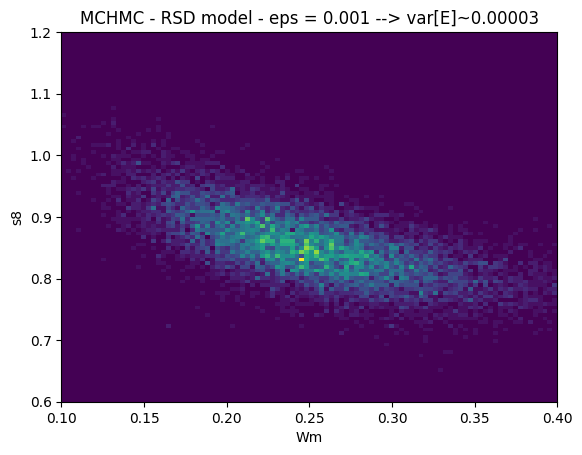

In [50]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [51]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 56.012314298562245
eps: 0.125 --> VarE: 43.45743791959747
eps: 0.0625 --> VarE: 5.851793488774597
eps: 0.03125 --> VarE: 1.9209069700538348
samples: 100--> ESS: 0.17553279009611092


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.68 seconds
Compute duration  = 1.68 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2523    0.0584     0.0006    0.0019   904.6336    1.0018     ⋯
          σ8    0.8524    0.0547     0.0005    0.0017   909.3976    1.0003     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1497    0.2115    0.2483    0.2888    0.3802
          σ8    0.7533    0.8150    0.8489    0.8863    0.9717


In [52]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.22 seconds
Compute duration  = 1.22 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2506    0.0561     0.0006    0.0018   953.7595    0.9999     ⋯
          σ8    0.8539    0.0538     0.0005    0.0017   935.1468    0.9999     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1494    0.2103    0.2476    0.2878    0.3675
          σ8    0.7577    0.8162    0.8513    0.8879    0.9702


In [38]:
#StatsPlots.plot(new_samples)

## NUTS

In [39]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 3.11 seconds
Compute duration  = 3.11 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2538    0.0595     0.0006    0.0011   2696.8724    0.9999    ⋯
          σ8    0.8518    0.0552     0.0006    0.0011   2627.5739    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [40]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.145867  0.840872  13.6381  1.0  1.0  …  1.0  0.0  0.678866  0.678866
 0.291631  0.903154  16.0849  3.0  1.0     2.0  0.0  0.678866  0.678866
 0.254748  0.884413  18.2969  3.0  1.0     1.0  0.0  0.678866  0.678866
 0.265175  0.890138  17.8103  7.0  1.0     3.0  0.0  0.678866  0.678866
 0.20951   0.810578  17.2109  3.0  1.0     2.0  0.0  0.678866  0.678866
 0.272688  0.877599  18.044   3.0  1.0  …  2.0  0.0  0.678866  0.678866
 0.26215   0.844847  18.8522  3.0  1.0     2.0  0.0  0.678866  0.678866
 0.289478  0.80032   18.4079  3.0  1.0     2.0  0.0  0.678866  0.678866
 0.2631    0.872164  18.444   7.0  1.0     3.0  0.0  0.678866  

In [41]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

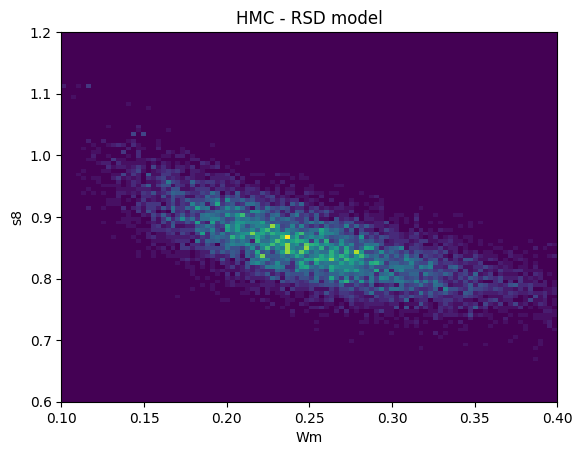

In [42]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");